# Training Models to Classify Driver Behaviors

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import LabelEncoder
from tsfresh.feature_extraction import extract_features
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

FOLDER_NAME = 'ufscar'

2025-02-05 10:53:45.884739: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-05 10:53:45.885343: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 10:53:45.887964: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 10:53:45.895358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738763625.907725   10754 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738763625.91

In [2]:
labels = pd.read_csv(f'{FOLDER_NAME}/data/labels.csv')
y = labels['Type'].values

label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

ids = labels['ID'].values
df_list = []
id_count = 0
for filename in ids:

    if filename.startswith('v'):
        continue

    path = filename + '.csv'
    df = pd.read_csv(os.path.join(f'{FOLDER_NAME}/data', path))
    df['id'] = id_count
    df_list.append(df)
    id_count += 1

X = pd.concat(df_list, axis=0, ignore_index=True)


In [19]:
print(y)
print(y_numeric)

['aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressive' 'aggressive' 'aggressive' 'aggressive' 'aggressive'
 'aggressi

## UMAP Sliding Windows

In [3]:
def create_sliding_windows(data, labels, window_size=15, step_size=5):
    # This function returns the sliding windows and the labels for each window
    # If output_3d is True, the output will be a 3D array, otherwise it will be a 2D array
    # The 2D array is (num_samples, num_features), useful for ML and the 3D array is (num_samples, window_size/time_steps, num_features), useful for RNNs
    # The difference is that the window is not flattened in the 3D array
    X = []
    y = []
    for k in range(len(data)):
        for i in range(0, len(data[k]) - window_size + 1, step_size):
            end = i + window_size

            if end > len(data[k]):
                end = len(data[k])
            
            window_label = labels[k] # Getting the most frequent event in the window
            window = data[k][i:end].drop(['time', 'id'], axis=1) # Dropping 'evento' and 'seconds_passed' columns

            if len(window) < window_size:
                padding = np.zeros((window_size - len(window), len(window.columns))) # Padding the window with zeros and the same amount of columns
                window = np.vstack([window, padding]) # Stacking the window and padding keeping the same order
            
            X.append(np.array(window).flatten())
            y.append(window_label)

    return np.array(X), np.array(y)

In [4]:
def visualize_umap_2d(data, y_numeric, n_neighbors=5, min_dist=0.1, metric='euclidean'):
    X_umap = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, metric=metric).fit_transform(data)
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_numeric, cmap='Spectral', s=5)
    plt.colorbar(boundaries=np.arange(len(np.unique(y_numeric))+1)-0.5).set_ticks(np.arange(len(np.unique(y_numeric))))
    plt.title("UMAP 2D")
    plt.show()

In [5]:
def visualize_umap_3d(data, labels=None, n_neighbors=15, min_dist=0.1, metric='euclidean', title="UMAP 3D Projection"):
    """
    Visualize UMAP embeddings in 3D.

    Parameters:
        data (np.array or pd.DataFrame): High-dimensional data to reduce.
        labels (np.array or pd.Series): Labels for coloring the points (optional).
        n_neighbors (int): Number of neighbors for UMAP.
        min_dist (float): Minimum distance between points in the UMAP embedding.
        metric (str): Distance metric for UMAP.
        title (str): Title of the plot.
    """
    # Perform UMAP dimensionality reduction to 3D
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=3,  # Reduce to 3 dimensions
        metric=metric,
        random_state=42
    )
    embedding = reducer.fit_transform(data)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    if labels is not None:
        scatter = ax.scatter(
            embedding[:, 0],  # X-axis
            embedding[:, 1],  # Y-axis
            embedding[:, 2],  # Z-axis
            c=labels,         # Color by labels
            cmap='Spectral',  # Colormap
            s=50,             # Point size
            alpha=0.8         # Transparency
        )
        # Add a colorbar
        cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
        cbar.set_label('Labels')
    else:
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            embedding[:, 2],
            s=50,
            alpha=0.8
        )

    # Set labels and title
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')
    ax.set_title(title)

    # Show the plot
    plt.show()

In [6]:
X_sliding, y_sliding = create_sliding_windows(df_list, y, window_size=20, step_size=10)
y_sliding = label_encoder.transform(y_sliding)
X_sliding.shape, y_sliding.shape

((9075, 100), (9075,))

In [ ]:
from dtaidistance.dtw import distance_matrix_fast
distance_matrix = distance_matrix_fast(X_sliding)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/renan/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/renan/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/renan/.local/lib/python3.10/site-packag

In [10]:
# Convert the distance matrix to a DataFrame
distance_matrix_df = pd.DataFrame(distance_matrix)

# Define the output path
output_path = os.path.join(FOLDER_NAME, 'distance_matrix', 'distance_matrix.csv')

# Ensure the directory exists
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Write the DataFrame to a CSV file
distance_matrix_df.to_csv(output_path, index=False)

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/renan/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


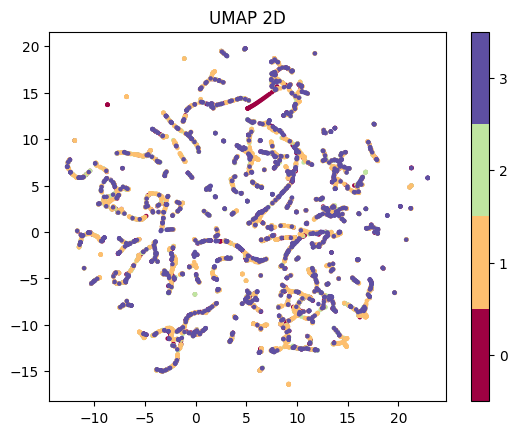

In [12]:
visualize_umap_2d(distance_matrix, y_sliding, n_neighbors=5, min_dist=0.1, metric='precomputed')

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


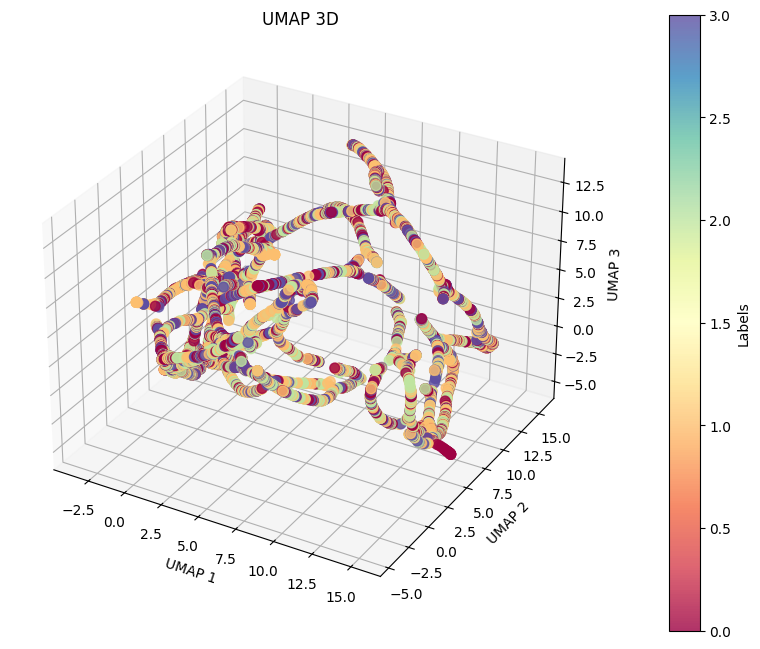

In [13]:
visualize_umap_3d(distance_matrix, y_sliding, n_neighbors=15, min_dist=0.1, metric='precomputed', title='UMAP 3D')

## Random Forest

Trying training a random forest in the data to verify the performance

In [25]:
def fit_RF(X_train, X_test, y_train, y_test, n_estimators=100, random_state=42):
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, classification_report(y_test, y_pred), y_pred

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_sliding, y_sliding, test_size=0.2, random_state=42)

In [27]:
clf, report, y_pred = fit_RF(X_train, X_test, y_train, y_test)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84       370
           1       0.89      0.92      0.91       612
           2       0.87      0.86      0.86       490
           3       0.84      0.83      0.83       343

    accuracy                           0.87      1815
   macro avg       0.86      0.86      0.86      1815
weighted avg       0.87      0.87      0.87      1815



## t-SNE

In [15]:
def visualize_tsne_2d(data, y_numeric, perplexity=30):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(data)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_numeric, cmap='viridis', s=5)
    plt.colorbar(boundaries=np.arange(len(np.unique(y_numeric))+1)-0.5).set_ticks(np.arange(len(np.unique(y_numeric))))
    plt.title('t-SNE 2D Projection')
    plt.show()

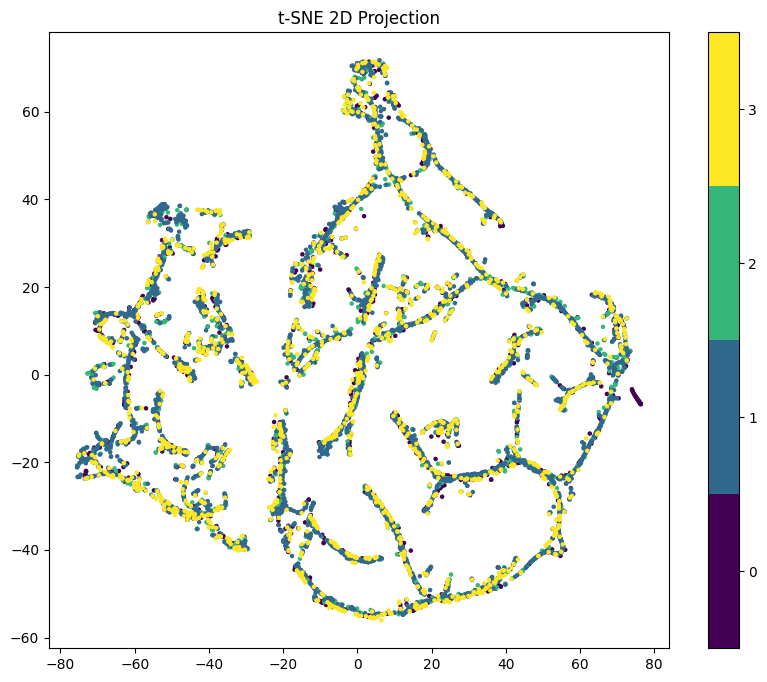

In [24]:
visualize_tsne_2d(X_sliding, y_sliding, perplexity=70)
